In [179]:
#load libraries
import numpy as np
from matplotlib import pyplot as plt 
import pandas as pd
from matplotlib.pyplot import figure
import re

global variables in the following cell need to be checked for every run

In [180]:
#some cheeky GLOBAL VARIABLES HERE (don't kill me Daniel!)
# this cell needs adjustments from run to run, depending which files one wants to investigate

#signal file numbers to use:
# 2 --> holder 1, 45 deg
# 3 --> holder 1, 90 deg
# 6 --> holder 1, 20 deg
# 7 --> holder 1, 60 deg, part 1 (interrupted)
# 8 --> holder 1, 60 deg (rest of the interrupted run)
# 9 --> holder 1, 75 deg

# 21 --> holder 2, 45 deg
# 23 --> holder 2, 75 deg
# 24 --> holder 2, 20 deg (first 3 samples)
# 25 --> holder 2, 20 deg (last 3 samples)
# 26 --> holder 2, 90 deg
# 27 --> holder 2, 60 deg

# 29 --> holder 3, 


file_number_signal = 27 #the file number corresponding to a scan (from Elettra logbook!)
incidence_angle = 60 #the angle of photon incidence - only is used in naming the file in which TEY is written into but still needs to be checked for each run to avoid confusion

file_number_dark_20nA = 4
file_number_dark_200pA = 5
file_number_photodiode = 14
file_number_photodiode_200pA_200pA = 17 #dark photodiode current file number, with Kiethley-B and Kiethley-A sensitivity values, respectively
file_number_photodiode_20nA_200pA = 16 #dark photodiode current file number, with Kiethley-B and Kiethley-A sensitivity values, respectively
file_number_photodiode_200nA_20nA = 15 #dark photodiode current file number, with Kiethley-B and Kiethley-A sensitivity values, respectively

regs_per_sample = 7 #number of regions per sample (7 pretty much all the time)
region_sensitivities = ["200pA", "200pA", "200pA", "200pA", "200pA", "20nA", "20nA"] #an ordered list with sample signal (current) sensitivities of photon energy regions!
PD_region_sensitivities = ["200pA_200pA", "200pA_200pA", "200pA_200pA", "200pA_200pA", "20nA_200pA", "200nA_20nA", "200nA_20nA"] #same but for photodiode (KB and KA had different readings)

#from the following, only one list of materials needs to be used (sample holder 1, 2 or 3)
#materials = ['Aerodag_SS', 'Graphite_SS', 'ITO_MLI', 'ITO_Radiator_1'] #materials on sample plate 1, ordered as they were investigated!
materials = ['Cu_tape', 'Au', 'ITO_MLI_1', 'ITO_MLI_2', 'Ag', 'fake_dust'] #materials on sample plate 2, ordered as they were investigated!

#materials = ['Cu_tape', 'Au', 'ITO_MLI_1'] #for file 24
#materials = ['ITO_MLI_2', 'Ag', 'fake_dust'] # for file 25

#materials = ['Aerodag_Al, ITO_Radiator_2']

eV = 1.602e-19 #C, elementary charge
delta_I_by_I = 0.02 #relative error of all current readings is cca 2%
R_err = 0.05 #relative error (in %) of the Photodiode Responsivity (actually not given - this is just my guess)
use_BPM_region_indexes = [] #indexes of regions in which normalization by BPM (rather than by monitor) should be used

function to read data from a text file:

In [181]:
#This function simply reads a BEAR output text file with data and outputs it as a bunch of lists
def read_file(filename):
    #just declaring a list for each column
    rel_t = [] #msec
    phot_E = [] #eV
    x = [] # Var_1, x spot position
    y = [] #Var_2, y spot position
    I_sample = [] # INSTR_1, Kiethley B: instrument 1 with sample + bias, current
    I_monitor = [] # INSTR_2, Kiethley A, instrument 2 (monitor)
    I_BPM_sum = [] #sum of BPM current measurements

    copy_lines = []
    with open (filename, "r", encoding='windows-1254') as myfile: #encoding change resolves an error coming from an extra \n at the end of files
        for l in myfile: #read lines until first occurence of this long line
            if "______________________________________________" in l:
                break
        for l in myfile: #read the file again until this appears
            if "______________________________________________" in l:
                break

        for l in myfile: #from then on, read all non-empty lines and split them on tab
            if l != "\n":
                line = l.strip() 
                line = re.split(r'\t+', line)
                copy_lines.append(line)

    #from each line, extract a name/number and append it into its relevant column
    for i in range(1,len(copy_lines)-1):
        line = copy_lines[i]

        rel_t.append(line[0])
        phot_E.append(line[1])
        x.append(line[2])
        y.append(line[3])
        I_sample.append(line[4])
        I_monitor.append(line[5])
        I_BPM_sum.append(line[7])

    #extracted values are still strings --> cast numbers to floats
    for i in range(0, len(rel_t)):
        rel_t[i] = float(rel_t[i])
        phot_E[i] = float(phot_E[i])
        x[i] = float(x[i])
        y[i] = float(y[i])
        I_sample[i] = float(I_sample[i])
        I_monitor[i] = float(I_monitor[i])
        I_BPM_sum[i] = float(I_BPM_sum[i])
    
    return([rel_t, phot_E, x, y, I_sample, I_monitor, I_BPM_sum])

In [182]:
def get_region_df(reg_filename, reg_number, material_name):
    # function that takes a filename (textfile that should contain BEAR data with a single region), the region number and material name, and outputs a dataframe with the data
    reg = read_file(reg_filename) #call the readfile function (defined above) and store real time, photon energy, beamspot coordinates (x,y), and current readings (sample, monitor, BPM sum)
    #organize the data into the dataframe and return it
    reg_data = {'rel_t': reg[0], 'phot_E': reg[1], 'x': reg[2], 'y': reg[3], 'I_sample': reg[4], 'I_monitor' : reg[5], 'I_BPM_sum': reg[6], 'reg_number': reg_number, 'material_name': material_name}
    reg_df = pd.DataFrame(data=reg_data)
    return(reg_df)

function to put data from multiple text files (multiple materials and regions) into a big dataframe

In [183]:
def concate_data(materials, regs_per_sample, file_number):
#A function that concates dataframes from all regions (each reagion read separately from its own file) into a large dataframe
    
    if "dark" in materials[0]: #for dark offsets ("dark" keyword needed instead of materials list), we use a single file, not regionwise --> different filename used
        df = get_region_df(f"20210802_arneodo/file(1)" + "{:04d}".format(file_number) + ".txt", 0, "no material (dark)") #get dataframe using get_region_df function
        return(df) 
    else: #for regular datafiles (not dark offset --> separate files for each region)
        all_run_regions = [] #list that will store dataframes to be concated
        for j in range(0,len(materials)): #for each material (cannot use 'for material in materials' because of the file numbering)
            material_name = materials[j] #copy name of the material
            
            for i in range(regs_per_sample * j + 1, regs_per_sample * (j+1) +1): #for each region corresponding to this material (note the region numbering!)
                #first material on a sample holder has files 1,...,7, second 8,...,14, etc
                
                append_this = get_region_df(f"20210802_arneodo/file(1)_Region {i}__" + "{:04d}".format(file_number) + ".txt",i, material_name) 
                all_run_regions.append(append_this) #append the dataframe to others

        df = pd.concat(all_run_regions, ignore_index=True, sort=False) #combine all region and material dataframes into a single large one, without sorting (done separately later)
    return(df)

calling the functions to actually extract the data:

In [184]:
#create signal dataframes:
df_signal = concate_data(materials, regs_per_sample, file_number_signal)

#create dark signal dataframes (for different sensitivity settings):
df_dark_20nA = concate_data(["dark"], regs_per_sample, file_number_dark_20nA)
df_dark_200pA = concate_data(["dark"], regs_per_sample, file_number_dark_200pA)

# create photodiode signal dataframe
df_photodiode = concate_data(["photodiode"], regs_per_sample, file_number_photodiode)

# get photodiode dark signal dataframes (for different sensitivity settings)
df_photodiode_dark_200pA_200pA = concate_data(["dark"], regs_per_sample, file_number_photodiode_200pA_200pA)
df_photodiode_dark_20nA_200pA = concate_data(["dark"], regs_per_sample, file_number_photodiode_20nA_200pA)
df_photodiode_dark_200nA_20nA = concate_data(["dark"], regs_per_sample, file_number_photodiode_200nA_20nA)

plotting dark current readings for 200pA sensitivity setting (for both KA and KB):

as opposed to the sample dark currents, the photodiode sometimes has a ramp-up phase --> plotting it here to make sure

0.05802576615108225


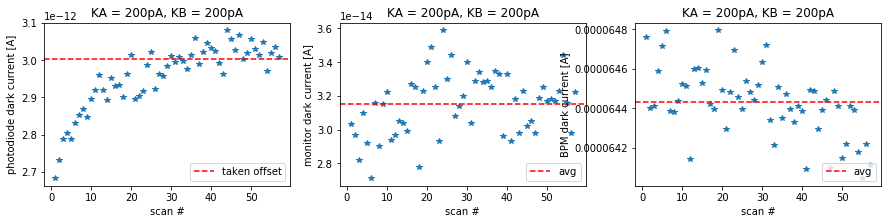

In [185]:
#photodiode dark offsets: KB 200pA, KA 200pA
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 3)) #initialize a double plot
plt1.plot(df_photodiode_dark_200pA_200pA['phot_E'], df_photodiode_dark_200pA_200pA['I_sample'], '*')
plt2.plot(df_photodiode_dark_200pA_200pA['phot_E'], df_photodiode_dark_200pA_200pA['I_monitor'], '*')
plt3.plot(df_photodiode_dark_200pA_200pA['phot_E'], df_photodiode_dark_200pA_200pA['I_BPM_sum'], '*')
plt1.set_ylabel('photodiode dark current [A]')
plt2.set_ylabel('monitor dark current [A]')
plt3.set_ylabel('BPM dark current [A]')
plt1.set_xlabel('scan #')
plt2.set_xlabel('scan #')
plt3.set_xlabel('scan #')
plt1.set_title('KA = 200pA, KB = 200pA')
plt2.set_title('KA = 200pA, KB = 200pA')
plt3.set_title('KA = 200pA, KB = 200pA')

# PD dark current in this setting resembles a square root function --> the actual offset should be taken from only the last bit (I take last third)
whole_bit = df_photodiode_dark_200pA_200pA['I_sample'].tolist()
last_bit = whole_bit[int(len(whole_bit)/3):]
PD_200pA_200pA_I_sample_offset = sum(last_bit)/len(last_bit)
PD_200pA_200pA_I_sample_stdev = np.std(last_bit)
plt1.axhline(y=PD_200pA_200pA_I_sample_offset, color='r', linestyle='--', label="taken offset")
plt1.legend(loc="lower right")

PD_200pA_200pA_I_monitor_offset = sum(df_photodiode_dark_200pA_200pA['I_monitor'].tolist())/len(df_photodiode_dark_200pA_200pA['I_monitor'].tolist())
PD_200pA_200pA_I_monitor_stdev = np.std(df_photodiode_dark_200pA_200pA['I_monitor'].tolist())
plt2.axhline(y=PD_200pA_200pA_I_monitor_offset, color='r', linestyle='--', label="avg")
plt2.legend(loc="lower right")
print(np.std(df_photodiode_dark_200pA_200pA['I_monitor'].tolist())/PD_200pA_200pA_I_monitor_offset)

PD_200pA_200pA_I_BPM_offset = sum(df_photodiode_dark_200pA_200pA['I_BPM_sum'].tolist())/len(df_photodiode_dark_200pA_200pA['I_BPM_sum'].tolist())
PD_200pA_200pA_I_BPM_stdev = np.std(df_photodiode_dark_200pA_200pA['I_BPM_sum'].tolist())
plt3.axhline(y=PD_200pA_200pA_I_BPM_offset, color='r', linestyle='--', label="avg")
plt3.legend(loc="lower right")

plotting dark current readings for 20nA (KB), 200pA (KA) sensitivity setting:

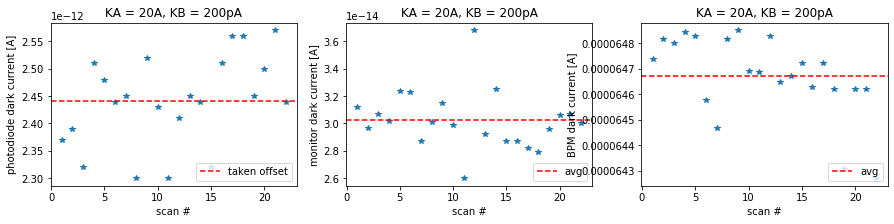

In [186]:
#photodiode dark offsets: KB 20nA, KA 200pA
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 3)) #initialize a double plot
plt1.plot(df_photodiode_dark_20nA_200pA['phot_E'], df_photodiode_dark_20nA_200pA['I_sample'], '*')
plt2.plot(df_photodiode_dark_20nA_200pA['phot_E'], df_photodiode_dark_20nA_200pA['I_monitor'], '*')
plt3.plot(df_photodiode_dark_20nA_200pA['phot_E'], df_photodiode_dark_20nA_200pA['I_BPM_sum'], '*')
plt1.set_ylabel('photodiode dark current [A]')
plt2.set_ylabel('monitor dark current [A]')
plt3.set_ylabel('BPM dark current [A]')
plt1.set_xlabel('scan #')
plt2.set_xlabel('scan #')
plt3.set_xlabel('scan #')
plt1.set_title('KA = 20A, KB = 200pA')
plt2.set_title('KA = 20A, KB = 200pA')
plt3.set_title('KA = 20A, KB = 200pA')

PD_20nA_200pA_I_sample_offset = sum(df_photodiode_dark_20nA_200pA['I_sample'].tolist())/len(df_photodiode_dark_20nA_200pA['I_sample'].tolist())
PD_20nA_200pA_I_sample_stdev = np.std(df_photodiode_dark_20nA_200pA['I_sample'].tolist())
plt1.axhline(y=PD_20nA_200pA_I_sample_offset, color='r', linestyle='--', label="taken offset")
plt1.legend(loc="lower right")

PD_20nA_200pA_I_monitor_offset = sum(df_photodiode_dark_20nA_200pA['I_monitor'].tolist())/len(df_photodiode_dark_20nA_200pA['I_monitor'].tolist())
PD_20nA_200pA_I_monitor_stdev = np.std(df_photodiode_dark_20nA_200pA['I_monitor'].tolist())
plt2.axhline(y=PD_20nA_200pA_I_monitor_offset, color='r', linestyle='--', label="avg")
plt2.legend(loc="lower right")

PD_20nA_200pA_I_BPM_offset = sum(df_photodiode_dark_20nA_200pA['I_BPM_sum'].tolist())/len(df_photodiode_dark_20nA_200pA['I_BPM_sum'].tolist())
PD_20nA_200pA_I_BPM_stdev = np.std(df_photodiode_dark_20nA_200pA['I_BPM_sum'].tolist())
plt3.axhline(y=PD_20nA_200pA_I_BPM_offset, color='r', linestyle='--', label="avg")
plt3.legend(loc="lower right")

plotting dark current readings for 200nA (KB), 20nA (KA) sensitivity setting:

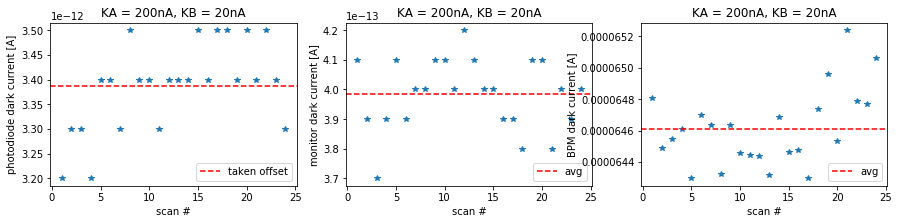

In [187]:
#photodiode dark offsets: KB 200nA, KA 20nA
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 3)) #initialize a double plot
plt1.plot(df_photodiode_dark_200nA_20nA['phot_E'], df_photodiode_dark_200nA_20nA['I_sample'], '*')
plt2.plot(df_photodiode_dark_200nA_20nA['phot_E'], df_photodiode_dark_200nA_20nA['I_monitor'], '*')
plt3.plot(df_photodiode_dark_200nA_20nA['phot_E'], df_photodiode_dark_200nA_20nA['I_BPM_sum'], '*')
plt1.set_ylabel('photodiode dark current [A]')
plt2.set_ylabel('monitor dark current [A]')
plt3.set_ylabel('BPM dark current [A]')
plt1.set_xlabel('scan #')
plt2.set_xlabel('scan #')
plt3.set_xlabel('scan #')
plt1.set_title('KA = 200nA, KB = 20nA')
plt2.set_title('KA = 200nA, KB = 20nA')
plt3.set_title('KA = 200nA, KB = 20nA')

PD_200nA_20nA_I_sample_offset = sum(df_photodiode_dark_200nA_20nA['I_sample'].tolist())/len(df_photodiode_dark_200nA_20nA['I_sample'].tolist())
PD_200nA_20nA_I_sample_stdev = np.std(df_photodiode_dark_200nA_20nA['I_sample'].tolist())
plt1.axhline(y=PD_200nA_20nA_I_sample_offset, color='r', linestyle='--', label="taken offset")
plt1.legend(loc="lower right")

PD_200nA_20nA_I_monitor_offset = sum(df_photodiode_dark_200nA_20nA['I_monitor'].tolist())/len(df_photodiode_dark_200nA_20nA['I_monitor'].tolist())
PD_200nA_20nA_I_monitor_stdev = np.std(df_photodiode_dark_200nA_20nA['I_monitor'].tolist())
plt2.axhline(y=PD_200nA_20nA_I_monitor_offset, color='r', linestyle='--', label="avg")
plt2.legend(loc="lower right")

PD_200nA_20nA_I_BPM_offset = sum(df_photodiode_dark_200nA_20nA['I_BPM_sum'].tolist())/len(df_photodiode_dark_200nA_20nA['I_BPM_sum'].tolist())
PD_200nA_20nA_I_BPM_stdev = np.std(df_photodiode_dark_200nA_20nA['I_BPM_sum'].tolist())
plt3.axhline(y=PD_200nA_20nA_I_BPM_offset, color='r', linestyle='--', label="avg")
plt3.legend(loc="lower right")

dark sample offsets taken from their respective dataframes:

In [188]:
##########
#sample dark current:
sample_I_dark_20nA = df_dark_20nA['I_sample'].tolist()
sample_I_dark_20nA_offset = sum(sample_I_dark_20nA)/len(sample_I_dark_20nA) 
sample_I_dark_20nA_stdev = np.std(sample_I_dark_20nA)

sample_I_dark_200pA = df_dark_200pA['I_sample'].tolist()
sample_I_dark_200pA_offset = sum(sample_I_dark_200pA)/len(sample_I_dark_200pA) 
sample_I_dark_200pA_stdev = np.std(sample_I_dark_200pA)

##########
#monitor dark current:
monitor_I_dark_20nA = df_dark_20nA['I_monitor'].tolist()
monitor_I_dark_20nA_offset = sum(monitor_I_dark_20nA)/len(monitor_I_dark_20nA)
monitor_I_dark_20nA_stdev = np.std(monitor_I_dark_20nA)

monitor_I_dark_200pA = df_dark_200pA['I_monitor'].tolist()
monitor_I_dark_200pA_offset = sum(monitor_I_dark_200pA)/len(monitor_I_dark_200pA)
monitor_I_dark_200pA_stdev = np.std(monitor_I_dark_200pA)

##########
#BPM dark current:
I_BPM_dark_20nA = df_dark_20nA['I_BPM_sum'].tolist()
I_BPM_dark_20nA_offset = sum(I_BPM_dark_20nA)/len(I_BPM_dark_20nA)
I_BPM_dark_20nA_stdev = np.std(I_BPM_dark_20nA)

I_BPM_dark_200pA = df_dark_200pA['I_BPM_sum'].tolist()
I_BPM_dark_200pA_offset = sum(I_BPM_dark_200pA)/len(I_BPM_dark_200pA)
I_BPM_dark_200pA_stdev = np.std(I_BPM_dark_200pA)


function to extract for specific region values from the overall dataframe and to correct for dark offsets:

In [189]:
def extract_reg(material_name, reg_number, df, I_sample_offset, I_monitor_offset, I_BPM_offset, rel_err, I_sample_stdev, I_monitor_stdev, I_BPM_stdev): 
    # function to extract plotting values for a specific material and region from the big dataframe
    # dark offsets are subtracting within this function (passed in as parameters)

    # extract sub-dataframe containing only specific region from a specific material
    criterion1 = df['material_name'] == material_name
    criterion2 = df['reg_number'] == reg_number
    material_df = df.loc[criterion1 & criterion2]
    
    # take columns from this sub-dataframe (generates Series format) and cast them to lists
    sample_I = material_df['I_sample'].tolist()
    monitor_I = material_df['I_monitor'].tolist()
    phot_E = material_df['phot_E'].tolist()
    I_BPM = material_df['I_BPM_sum'].tolist()

    #subtract dark current offsets:
    sample_I = [val - I_sample_offset for val in sample_I]
    monitor_I = [val - I_monitor_offset for val in monitor_I]
    I_BPM = [val - I_BPM_offset for val in I_BPM]
    
    #calculate errors on each current value
    sample_I_err, monitor_I_err, I_BPM_err = [],[],[]
    for val in sample_I: #the error is either global relative error times the current value, or the standard deviation from dark readings (if greater)
        if I_sample_stdev/val >= rel_err:
            sample_I_err.append(I_sample_stdev)
        else:
            sample_I_err.append(val * rel_err)

    for val in monitor_I: 
        if I_monitor_stdev/val >= rel_err:
            monitor_I_err.append(I_monitor_stdev)
        else:
            monitor_I_err.append(val * rel_err)

    for val in I_BPM: 
        if I_BPM_stdev/val >= rel_err:
            I_BPM_err.append(I_BPM_stdev)
        else:
            I_BPM_err.append(val * rel_err)


    #divide sample current by either monitor or BPM current:
    norm_I_byMonit = [i / j for i, j in zip(sample_I, monitor_I)]
    norm_I_byBPM = [i / j for i, j in zip(sample_I, I_BPM)]

    #calculate error for the fractions:
    norm_I_byMonit_err = [np.sqrt((dIs/Im)**2 + (Is*dIm/(Im**2))**2) for dIs,Im,Is,dIm in zip(sample_I_err,monitor_I,sample_I,monitor_I_err)]
    norm_I_byBPM_err = [np.sqrt((dIs/Ibpm)**2 + (Is*dIbpm/(Ibpm**2))**2) for dIs,Ibpm,Is,dIbpm in zip(sample_I_err,I_BPM,sample_I,I_BPM_err)]

    return([sample_I, monitor_I, phot_E, I_BPM, norm_I_byMonit, norm_I_byBPM, sample_I_err, monitor_I_err, I_BPM_err, norm_I_byMonit_err, norm_I_byBPM_err])

#The following  needs some explanation. There are several materials, each with numerous regions (that need separate plotting due to normalization), 
#and each region contains multiple lists with different kinds of data (currents, photon energy, etc.)
#to avoid cluttering the code with variables, everything is put into a master-list of multiple dimensions (4, I guess)
#data is then accessed and plotted with simple indexing

In [190]:
MATERIALS = [] #Master multi-dimension list

count = 1 #again, there's need for this weird counting (material one has 1,..,7, material two 8,...,14, etc.)
for material_name in materials: #for each material name in the list (among globals!)
    MAT = [] #this sub-master list will contain regions
    for i in range(count, count+regs_per_sample): #for each region within a material
        #pick the right sensitivity setting --> if statement
        if region_sensitivities[count % regs_per_sample] == "20nA":
            #append sub-master list with region-specific data extracted from the large dataframe using extract_reg function
            MAT.append(extract_reg(material_name, i, df_signal, sample_I_dark_20nA_offset, monitor_I_dark_20nA_offset, I_BPM_dark_20nA_offset, delta_I_by_I, sample_I_dark_20nA_stdev, monitor_I_dark_20nA_stdev, I_BPM_dark_20nA_stdev))
        elif region_sensitivities[count % regs_per_sample] == "200pA":
            MAT.append(extract_reg(material_name, i, df_signal, sample_I_dark_200pA_offset, monitor_I_dark_200pA_offset, I_BPM_dark_200pA_offset, delta_I_by_I, sample_I_dark_200pA_stdev, monitor_I_dark_200pA_stdev, I_BPM_dark_200pA_stdev))
    MATERIALS.append(MAT) #once all regions from material extracted, append sub-master list into master list
    count += regs_per_sample


data from one sample-plate run can now be accesed via integer indexing:
MATERIALS[material_index][region_index][data_choice], data_choices written below:

The following is then a cell for quick plotting and checking the data:

(0, 5.404054090909091e-12)

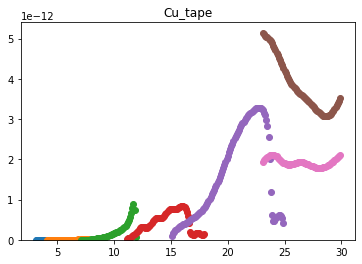

In [191]:
marker = 'o'

# plot options for xvals and yvals:
# 0 --> sample_I
# 1 --> monitor_I
# 2 --> phot_E
# 3 --> I_BPM
# 4 --> norm_I_byMonit
# 5 --> norm_I_byBPM
# 6 --> sample_I error (absolute)
# 7 --> moitor_I error (absolute)
# 8 --> I_BPM error (absolute)
# 9 --> norm_I_byMonit error (absolute)
# 10 --> norm_I_byBPM error (absolute)

x_choice = 2
y_choice = 0

material_index = 0

for region_index in range(0, regs_per_sample): #plot region-by-region (each with different color)
    plt.plot(MATERIALS[material_index][region_index][x_choice], MATERIALS[material_index][region_index][y_choice], marker)
    plt.title(materials[material_index])

plt.gca().set_ylim(bottom=0)
#plt.gca().set_ylim(top=0.002)


In [192]:
def convert_eV_to_wavelength(energy_eV_list):
    # a simple function that takes a list with photon energy values (in eV) and converts them into wavelength in nanometers
    eV = 1.602*10e-19 #Joule, electronvolt
    h = 6.62607004*10e-34 #J*s, planck constant
    c = 3*10e8 #m/s', speed of light
    wavelength_list = []
    for datapoint in energy_eV_list:
        energy_J = datapoint * eV
        wavelength_list.append(h*c/energy_J/(10e-9)) #in nm
    return(wavelength_list)

In [193]:
#Work function values extrapolated from Modena measurements
ITO_WF = 3.95 #eV
Graphite_WF = 4.21 #eV
Aerodag_WF = 3.45

next, a textfile with photodiode responsivity is taken and a function generated from the datapoints.

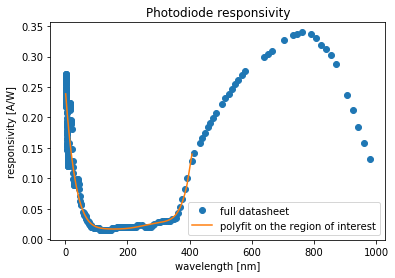

In [194]:
# load photodiode responsivity from a textfile:
lambda_nm, responsivity = [],[] #responsivity in Amperes per Watt!

filename = "sxuv_responsivity.txt"
startline = 3 #first two lines are useless

copy_lines=[]
with open(filename) as f:
    lines = f.readlines()

for line in lines:
    split_line = line.split()
    copy_lines.append(split_line)

    #from each line, extract a name/number and append it into its relevant column
for i in range(startline-1,len(copy_lines)-1):
    line = copy_lines[i]

    lambda_nm.append(line[0])
    responsivity.append(line[1])

    #extracted values are still strings --> cast numbers to floats
for i in range(0, len(lambda_nm)):
    lambda_nm[i] = float(lambda_nm[i])
    responsivity[i] = float(responsivity[i])

#plot responsivity
plt.plot(lambda_nm, responsivity, 'o', label="full datasheet")
plt.xlabel('wavelength [nm]')
plt.ylabel('responsivity [A/W]')
plt.title('Photodiode responsivity')

#I want to fit the responsivity function, however, I need not worry about wavelengths above cca 413nm (3eV photon energy)
# so I make a copy of the responsivity up until that wavelength and fit this instead:
lambda_nm_2 = [i for i in lambda_nm if i <= 413]
responsivity_2 = responsivity[:len(lambda_nm_2)]

responsivity_fit = np.poly1d(np.polyfit(lambda_nm_2, responsivity_2, 6)) #make a polynomial fit (I wiggled with the order, 6 seems to be very good) and plot it
plt.plot(lambda_nm_2, responsivity_fit(lambda_nm_2), '-', label="polyfit on the region of interest")
plt.legend(loc="lower right")


next, the right offset will be chosen for each region, and the previously defined functions called to actually calculate the first fraction (I_sample/I_monitor) of the total electorn yield (TEY) + its errors

In [195]:
#Note: 
#the Total Electron Yield (TEY) for a specific photon energy is calculated as follows:
# TEY = ((I_sample - I_sample_offset)/(I_control_t1 - I_control_offset_t1)) * ((I_control_t2 - I_control_offset_t2)/(I_photodiode - I_photodiode_offset)) * (photodiode_Responsivity * photon_energy_in_eV)

# for simplicity, and for easier error propagation, the formula is implemented in 3 factors, each calculated separately:
# TEY = FIRST_FRAC * SECOND_FRAC * FACTOR
# where:
# FIRST_FRAC = ((I_sample - I_sample_offset)/(I_control_t1 - I_control_offset_t1))
# SECOND_FRAC = ((I_control_t2 - I_control_offset_t2)/(I_photodiode - I_photodiode_offset))
# FACTOR = (photodiode_Responsivity * photon_energy_in_eV)

#just offset placeholders here
PD_I_monitor_offset = 0
PD_current_offset = 0
PD_BPM_I_offset = 0

#dark currents in photodiode measurements were not constant, rather increasing initially and then plateuing --> need to do a fit (done abovd)
PHOTODIODE = [] #master list for the Photodiode data
SECOND_FRAC = [] #master list for the second fraction (I_monitor/I_photodiode) data
SECOND_FRAC_ERR = [] #master list for the second fraction (I_monitor/I_photodiode) data error
FACTOR = [] #master list for the final factor of the TEY calculation (includes Responsivity and an elementary charge)
FACTOR_ERR = [] 

for i in range(1, regs_per_sample+1): #for each region
    #pick the right sensitivity sentting (among globals, there is an ordered list of photodiode sensitivity settings for all regions!)
    if PD_region_sensitivities[i-1] == "200pA_200pA":
        PD_I_monitor_offset = PD_200pA_200pA_I_monitor_offset #set  the right monitor offset for run with photodiode
        PD_I_monitor_stdev = PD_200pA_200pA_I_monitor_stdev
        PD_current_offset = PD_200pA_200pA_I_sample_offset #set the right photodiode offset
        PD_current_stdev = PD_200pA_200pA_I_sample_stdev
        PD_BPM_I_offset = PD_200pA_200pA_I_BPM_offset  #set the right BPM offset for photodiode run
        PD_BPM_I_stdev = PD_200pA_200pA_I_BPM_stdev
    
    elif PD_region_sensitivities[i-1] == "20nA_200pA":
        PD_I_monitor_offset = PD_20nA_200pA_I_monitor_offset
        PD_I_monitor_stdev = PD_20nA_200pA_I_monitor_stdev
        PD_current_offset = PD_20nA_200pA_I_sample_offset
        PD_current_stdev = PD_20nA_200pA_I_sample_stdev
        PD_BPM_I_offset = PD_20nA_200pA_I_BPM_offset
        PD_BPM_I_stdev = PD_20nA_200pA_I_BPM_stdev

    elif PD_region_sensitivities[i-1] == "200nA_20nA":
        PD_I_monitor_offset = PD_200nA_20nA_I_monitor_offset
        PD_I_monitor_stdev = PD_200nA_20nA_I_monitor_stdev
        PD_current_offset = PD_200nA_20nA_I_sample_offset
        PD_current_stdev = PD_200nA_20nA_I_sample_stdev
        PD_BPM_I_offset = PD_200nA_20nA_I_BPM_offset
        PD_BPM_I_stdev = PD_200nA_20nA_I_BPM_stdev
    
    else: print("DID NOT FIND PD OFFSET!") #if offset not found for some reason, let me know

    #print(PD_I_monitor_offset,PD_current_offset,PD_BPM_I_offset) #check offsets
    
    #extract region-wise data for the photodiode run (using the () function) and append into a master list
    [PD_sample_I, PD_monitor_I, PD_phot_E, PD_I_BPM, PD_norm_I_byMonit, PD_norm_I_byBPM, PD_sample_I_err, PD_monitor_I_err, PD_I_BPM_err, PD_norm_I_byMonit_err, PD_norm_I_byBPM_err] = extract_reg("photodiode", i, df_photodiode, PD_current_offset, PD_I_monitor_offset, PD_BPM_I_offset, delta_I_by_I, PD_current_stdev, PD_I_monitor_stdev, PD_BPM_I_stdev)
    PHOTODIODE.append([PD_sample_I, PD_monitor_I, PD_phot_E, PD_I_BPM, PD_norm_I_byMonit, PD_norm_I_byBPM, PD_sample_I_err, PD_monitor_I_err, PD_I_BPM_err, PD_norm_I_byBPM_err, PD_norm_I_byBPM])

    #now calculate the second fraction of the TEY calculation. It's similar to the first fraction, though  it's reciprocal
    if i in use_BPM_region_indexes: #some regions have to be controlled by BPM, not by monitor current - these regions (their indexes) need to be allocated among globals in a list!
        second_fraction = [1 / val for val in PD_norm_I_byBPM] 
        second_fraction_err = [dX / (X**2) for X,dX in zip(PD_norm_I_byBPM, PD_norm_I_byBPM_err)]
    else:
        second_fraction = [1 / val for val in PD_norm_I_byMonit] #second fraction can be found as a reciprocal of one of the outputs from extract_reg() upon passing photodiode data!
        second_fraction_err = [dX / (X**2) for X,dX in zip(PD_norm_I_byMonit, PD_norm_I_byMonit_err)]

    SECOND_FRAC.append(second_fraction)
    SECOND_FRAC_ERR.append(second_fraction_err)
    
    R = responsivity_fit(convert_eV_to_wavelength(PD_phot_E))
    factor = [i*j for i,j in zip(R, PD_phot_E)]
    factor_err = [R_err * val for val in factor]
    FACTOR.append(factor)
    FACTOR_ERR.append(factor_err)


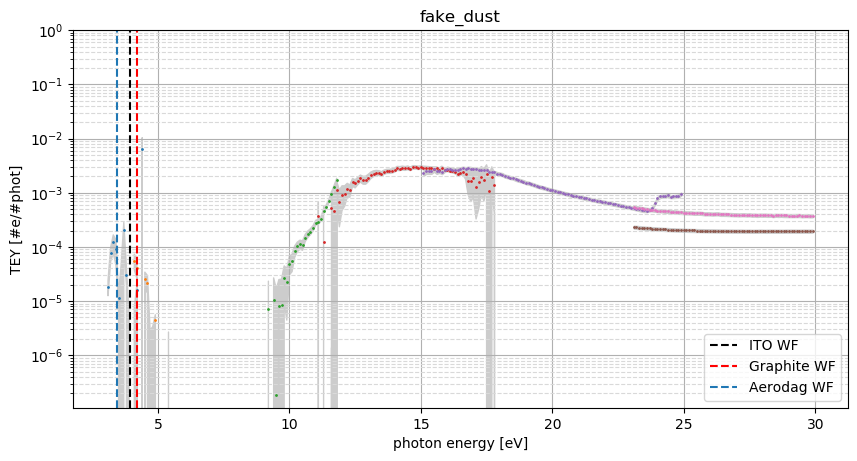

In [214]:
figure(figsize=(10, 5), dpi=100)
lines = ['photon_energy_eV    total_yield    yield_error'] #data will be written into a file in this format

material_index = 5

for region_index in range(0, regs_per_sample):
    if region_index in use_BPM_region_indexes:
        FIRST_FRAC = MATERIALS[material_index][region_index][5]
        FIRST_FRAC_ERR = MATERIALS[material_index][region_index][10]

    else:
        FIRST_FRAC = MATERIALS[material_index][region_index][4]
        FIRST_FRAC_ERR = MATERIALS[material_index][region_index][9]

    TEY_reg = [i * j * k for i,j,k in zip(FIRST_FRAC, SECOND_FRAC[region_index], FACTOR[region_index])]
    TEY_reg_err = [np.sqrt((dF1*F2*F3)**2 + (F1*dF2*F3)**2 + (F1*F2*dF3)**2) for F1,F2,F3,dF1,dF2,dF3 in zip(FIRST_FRAC,SECOND_FRAC[region_index],FACTOR[region_index],FIRST_FRAC_ERR, SECOND_FRAC_ERR[region_index],FACTOR_ERR[region_index])]

    phot_E_reg = MATERIALS[material_index][region_index][2]

    for l in range(0, len(phot_E_reg)): #for the region, append line by line the text array that will be converted intp a textfile afterwards
        if TEY_reg[l] > 0: #do not record non-sense negative yield (usually results from offset subtraction)
            if phot_E_reg[l] >= 5:
                if (region_index == 1 and phot_E_reg[l] <= 7.5):
                    line = str(phot_E_reg[l]) + ' ' + str(TEY_reg[l]) + ' ' + str(TEY_reg_err[l])
                    lines.append(line)
                elif (region_index == 2 and phot_E_reg[l] >= 7.5 and phot_E_reg[l] <= 11.89):
                    line = str(phot_E_reg[l]) + ' ' + str(TEY_reg[l]) + ' ' + str(TEY_reg_err[l])
                    lines.append(line)
                elif (region_index == 3 and phot_E_reg[l] >= 11.9 and phot_E_reg[l] <= 16.5):
                    line = str(phot_E_reg[l]) + ' ' + str(TEY_reg[l]) + ' ' + str(TEY_reg_err[l])
                    lines.append(line)
                elif (region_index == 4 and phot_E_reg[l] >= 16.5 and phot_E_reg[l] <= 23.5):
                    line = str(phot_E_reg[l]) + ' ' + str(TEY_reg[l]) + ' ' + str(TEY_reg_err[l])
                    lines.append(line)
                elif (region_index == 6 and phot_E_reg[l] >= 23.5):
                    line = str(phot_E_reg[l]) + ' ' + str(TEY_reg[l]) + ' ' + str(TEY_reg_err[l])
                    lines.append(line)

    plt.fill_between(phot_E_reg, [i-j for i,j in zip(TEY_reg,TEY_reg_err)], [i+j for i,j in zip(TEY_reg,TEY_reg_err)], color='0.8')
    plt.plot(phot_E_reg, TEY_reg, marker, markersize=1)
    
plt.yscale('log')
plt.title(materials[material_index])

plt.xlabel('photon energy [eV]')
plt.ylabel('TEY [#e/#phot]')
plt.grid(linestyle='--')
plt.grid(which = 'major', linestyle='-')
plt.grid(which = 'minor', linestyle='--', color='0.85')
plt.gca().set_ylim(top=1)

plt.axvline(x=ITO_WF, color='k', linestyle='--', label="ITO WF")
plt.axvline(x=Graphite_WF, color='r', linestyle='--', label="Graphite WF")
plt.axvline(x=Aerodag_WF, linestyle='--', label="Aerodag WF")
plt.legend(loc="lower right")

next, I want to save the data plotted above --> for that purpose, I'll write the yield vs energy into a text file and use these files separately elsewhere. The data will contain errors and will be separated by regions (so that the ugly tails of each region can be trimmed separately)

In [215]:
with open('TEY_files/' + str(materials[material_index]) + '_' + str(incidence_angle) + 'deg' + '.txt', 'w') as f:
    f.write('\n'.join(lines))

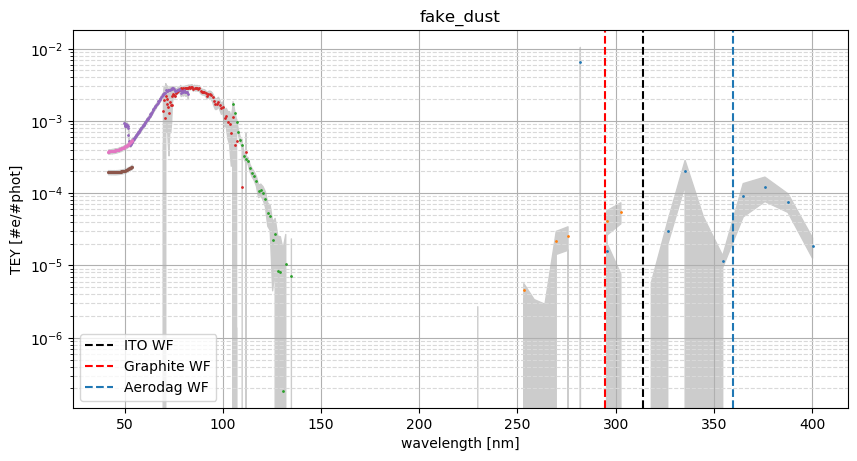

In [216]:
figure(figsize=(10, 5), dpi=100)

for region_index in range(0, regs_per_sample):
    
    FIRST_FRAC = MATERIALS[material_index][region_index][4]
    FIRST_FRAC_ERR = MATERIALS[material_index][region_index][9]

    TEY_reg = [i * j * k for i,j,k in zip(FIRST_FRAC, SECOND_FRAC[region_index], FACTOR[region_index])]
    TEY_reg_err = [np.sqrt((dF1*F2*F3)**2 + (F1*dF2*F3)**2 + (F1*F2*dF3)**2) for F1,F2,F3,dF1,dF2,dF3 in zip(FIRST_FRAC,SECOND_FRAC[region_index],FACTOR[region_index],FIRST_FRAC_ERR, SECOND_FRAC_ERR[region_index],FACTOR_ERR[region_index])]

    phot_E_reg = MATERIALS[material_index][region_index][2]
    
    plt.fill_between(convert_eV_to_wavelength(phot_E_reg), [i-j for i,j in zip(TEY_reg,TEY_reg_err)], [i+j for i,j in zip(TEY_reg,TEY_reg_err)], color='0.8')
    plt.plot(convert_eV_to_wavelength(phot_E_reg), TEY_reg, marker, markersize=1)
    plt.yscale('log')
    plt.title(materials[material_index])

plt.xlabel('wavelength [nm]')
plt.ylabel('TEY [#e/#phot]')
plt.grid(linestyle='--')
plt.grid(which = 'major', linestyle='-')
plt.grid(which = 'minor', linestyle='--', color='0.85')
#plt.xlim(120,220)
#plt.ylim((10e-7,10e-2))

plt.axvline(x=convert_eV_to_wavelength([ITO_WF])[0], color='k', linestyle='--', label="ITO WF")
plt.axvline(x=convert_eV_to_wavelength([Graphite_WF])[0], color='r', linestyle='--', label="Graphite WF")
plt.axvline(x=convert_eV_to_wavelength([Aerodag_WF])[0], linestyle='--', label="Aerodag WF")
plt.legend(loc="lower left")